In [248]:
import os
import pandas as pd
import sys
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import xgboost
from xgboost import XGBClassifier

base_repo_dir = os.path.abspath("../")
sys.path.append(base_repo_dir)

In [249]:
df = pd.read_csv(str(base_repo_dir) + "/data/rangeland_data_wrk.csv")
df.head()

,shp_id,x_coor,y_coor,aimag_eng,soum_eng,soum_length,soum_area,year,asid,ndvi,...,wgr_smr_gdd5,wgr_smr_wd1,wgr_smr_wd2,water.dummy,desert.dummy,desert.steppe.dummy,mountain.dummy,steppe.dummy,forest.steppe.dummy,taiga.dummy
0,262,108.345238,47.824459,Ulaanbaatar,Baganuur,101.081641,636.926215,1971,1101,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,262,108.345238,47.824459,Ulaanbaatar,Baganuur,101.081641,636.926215,1972,1101,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,262,108.345238,47.824459,Ulaanbaatar,Baganuur,101.081641,636.926215,1973,1101,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,262,108.345238,47.824459,Ulaanbaatar,Baganuur,101.081641,636.926215,1974,1101,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,262,108.345238,47.824459,Ulaanbaatar,Baganuur,101.081641,636.926215,1975,1101,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [250]:
missing_columns = df.columns[df.isna().any()].tolist()
missing_columns.remove("bms")
df = df.drop(columns = ["soum_eng", "aimag_eng"])

In [251]:
#df = df[df["bms"].isnull() == False]
train_df = df.dropna(subset = ["bms"])
test_df = df[df["bms"].isna()]

In [252]:
train_df.to_csv("training.csv")

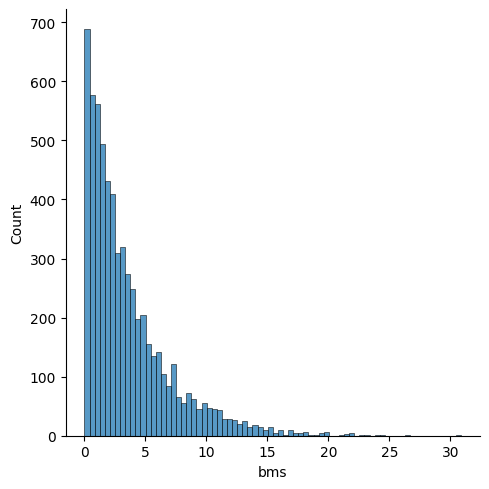

In [253]:
sns.displot(train_df["bms"])

In [254]:
def make_bms_class(
    row
):
    if row < 5:
        return "LOW"
    if row >= 5 and row <= 10:
        return "MEDIUM"
    if row > 10:
        return "HIGH"

In [255]:
train_df["bms"] = train_df.apply(lambda x: make_bms_class(x["bms"]), axis = 1)

/var/folders/rn/d2868tq11gjbfjp0xwssgqg40000gn/T/ipykernel_72383/878461482.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["bms"] = train_df.apply(lambda x: make_bms_class(x["bms"]), axis = 1)


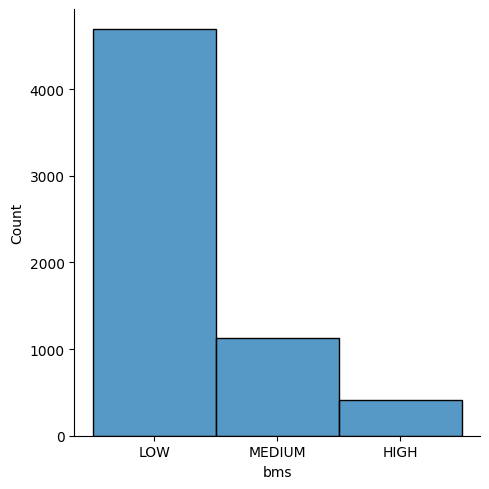

In [256]:
sns.displot(train_df["bms"])

#### Will train on training set
#### Will predict on training set
#### Will evaluate on training set
#### Apply predictions to test set

In [257]:
y_train = train_df["bms"]
x_train = train_df.drop(columns = ["bms"])
y_test = test_df["bms"]
x_test = test_df.drop(columns = ["bms"])

In [258]:
x_train = x_train.drop(columns = missing_columns)
x_test = x_test.drop(columns = missing_columns)

In [259]:
x_train.columns

Index(['shp_id', 'x_coor', 'y_coor', 'soum_length', 'soum_area', 'year',
       'asid', 'herdsize'],
      dtype='object')

In [260]:
CLASS_DICT = {
    "LOW": 0,
    "MEDIUM": 1,
    "HIGH": 2
}

In [261]:
y_train = y_train.map(CLASS_DICT)

In [262]:
y_train.value_counts()

0    4690
1    1123
2     408
Name: bms, dtype: int64

In [263]:
x_train.head()

,shp_id,x_coor,y_coor,soum_length,soum_area,year,asid,herdsize
489,147,114.573242,48.067448,71.266769,314.766532,2001,2101,301.058
490,147,114.573242,48.067448,71.266769,314.766532,2002,2101,217.175
491,147,114.573242,48.067448,71.266769,314.766532,2003,2101,198.457
492,147,114.573242,48.067448,71.266769,314.766532,2004,2101,208.032
493,147,114.573242,48.067448,71.266769,314.766532,2005,2101,199.726


In [271]:
x_test.head()

,shp_id,x_coor,y_coor,soum_length,soum_area,year,asid,herdsize
0,262,108.345238,47.824459,101.081641,636.926215,1971,1101,0.0
1,262,108.345238,47.824459,101.081641,636.926215,1972,1101,0.0
2,262,108.345238,47.824459,101.081641,636.926215,1973,1101,0.0
3,262,108.345238,47.824459,101.081641,636.926215,1974,1101,0.0
4,262,108.345238,47.824459,101.081641,636.926215,1975,1101,0.0


In [264]:
model = XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [265]:
predictions = model.predict(x_train)
accuracy_score(predictions, y_train)

0.9782993087927986

In [266]:
model.predict(x_test)

array([0, 0, 0, ..., 0, 0, 0])

In [269]:
model = DecisionTreeClassifier()
model.fit(x_train, y_train)

DecisionTreeClassifier()

In [270]:
predictions = model.predict(x_train)
accuracy_score(predictions, y_train)

1.0